In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)

shap.initjs()


In [3]:
from google.colab import files
uploaded = files.upload()


Saving diabetes.csv to diabetes.csv


In [4]:
df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()


(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data Cleaning & Preprocessing

In [5]:
cols_with_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
imputer = SimpleImputer(missing_values=0, strategy='median')
df[cols_with_zero] = imputer.fit_transform(df[cols_with_zero])

X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

Exploratory Data Analysis

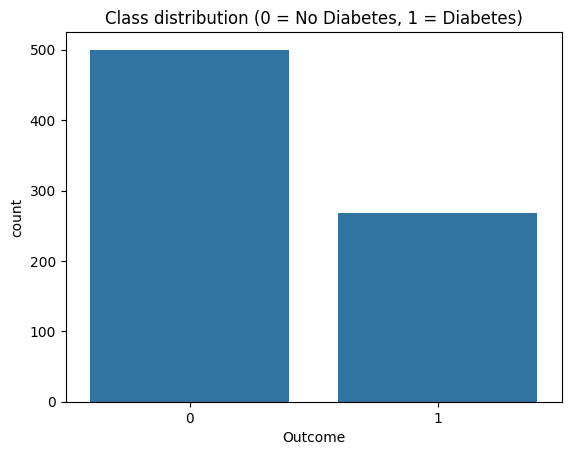

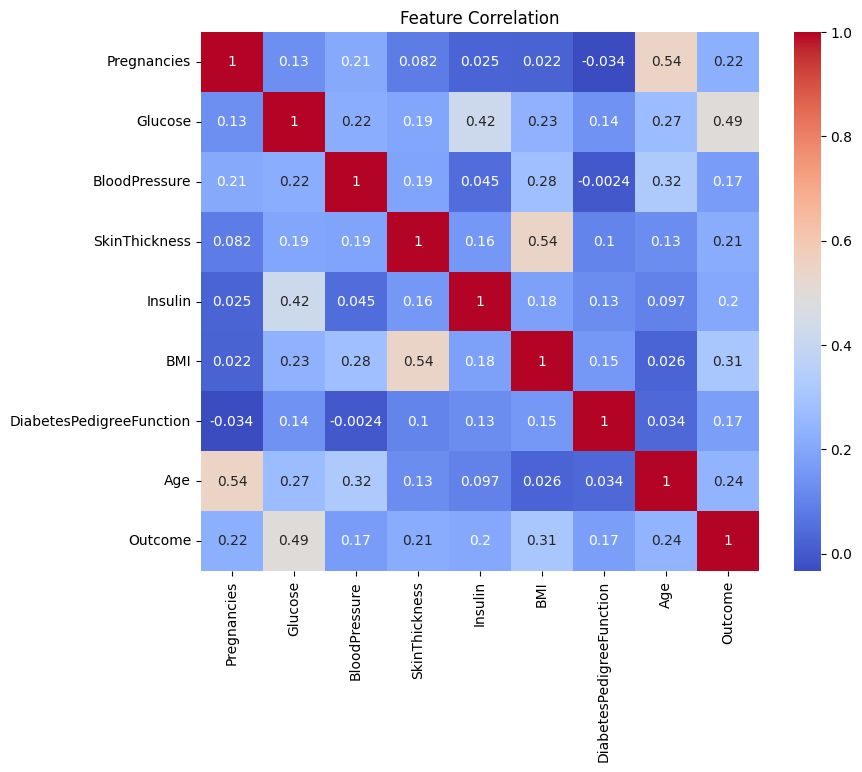

In [6]:
sns.countplot(x='Outcome', data=df)
plt.title("Class distribution (0 = No Diabetes, 1 = Diabetes)")
plt.show()

corr = df.corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


Train Multiple Models

In [7]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:28:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate Models

In [8]:
models = {
    "Logistic Regression": (lr, X_test_scaled),
    "Random Forest": (rf, X_test),
    "XGBoost": (xgb_clf, X_test)
}

for name, (model, X_eval) in models.items():
    y_pred = model.predict(X_eval)
    y_prob = model.predict_proba(X_eval)[:,1]
    print(f"----- {name} -----")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print()


----- Logistic Regression -----
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

ROC AUC: 0.812962962962963

----- Random Forest -----
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154

ROC AUC: 0.8161111111111111

----- XGBoost -----
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76    

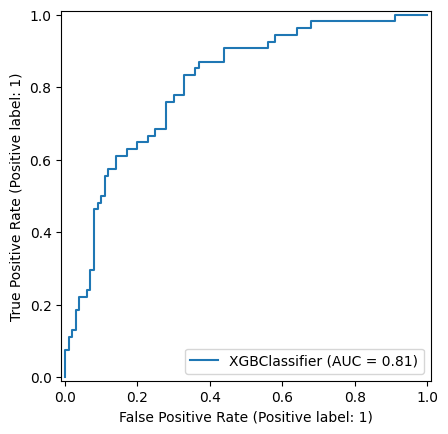

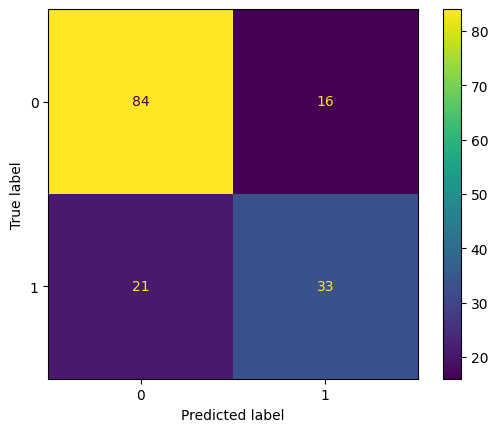

In [9]:
RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
plt.show()
ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test)
plt.show()


In [31]:
import joblib

# Save both model and scaler
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ best_model.pkl and scaler.pkl have been saved successfully!")


✅ best_model.pkl and scaler.pkl have been saved successfully!


In [30]:
from google.colab import files

files.download("best_model.pkl")
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

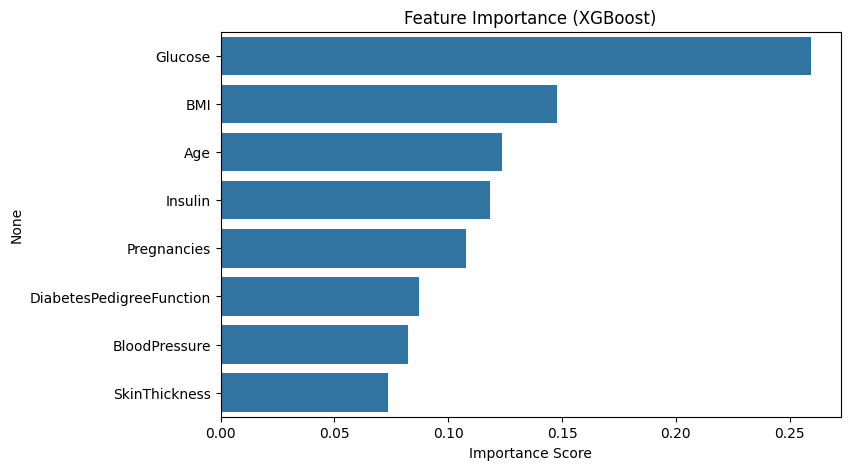

In [32]:
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.show()


ExactExplainer explainer: 155it [00:14,  4.14it/s]                         


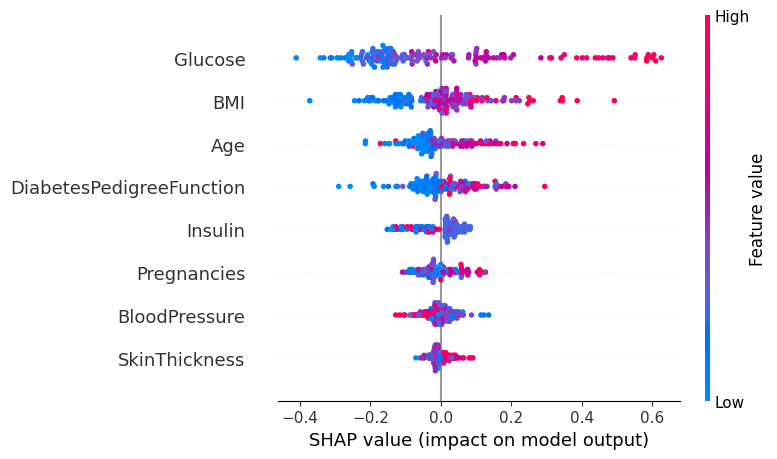

In [33]:
import shap
explainer = shap.Explainer(best_model.predict_proba, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values.values[:, :, 1], X_test, feature_names=X.columns)

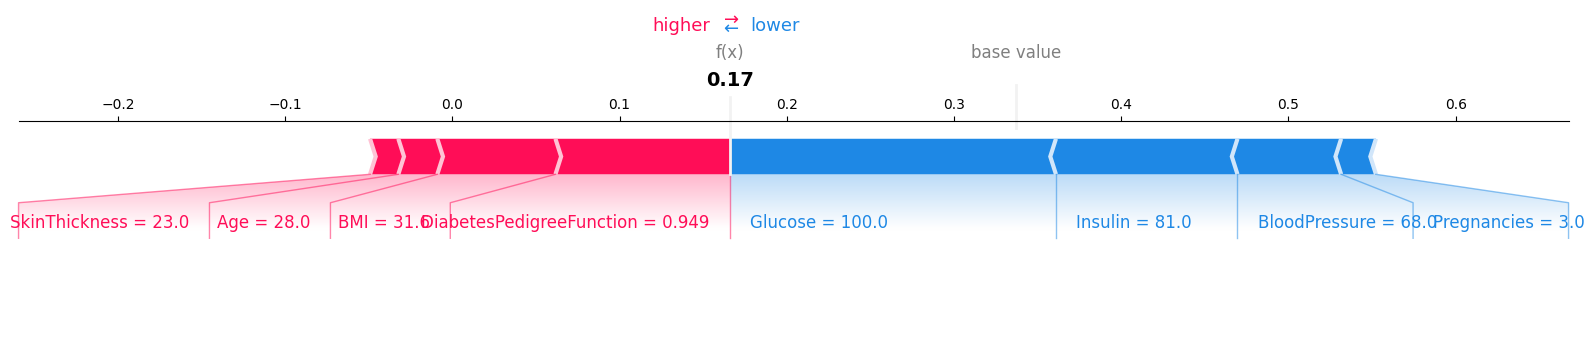

In [34]:
sample = X_test.iloc[5:6]
expected_value_for_positive_class = best_model.predict_proba(X_test)[:, 1].mean()

shap.force_plot(
    expected_value_for_positive_class,
    shap_values[5].values[:, 1],
    sample,
    matplotlib=True
)

Make Predictions on New Data

In [35]:
# Example input
new_patient = pd.DataFrame([{
    'Pregnancies':2, 'Glucose':140, 'BloodPressure':80,
    'SkinThickness':25, 'Insulin':85, 'BMI':32.0,
    'DiabetesPedigreeFunction':0.45, 'Age':35
}])

scaled_input = scaler.transform(new_patient)
pred_prob = best_model.predict_proba(scaled_input)[0,1]
pred_label = "High Risk of Diabetes" if pred_prob>0.5 else "Low Risk"

print(f"Prediction: {pred_label} (Probability = {pred_prob:.2f})")


Prediction: Low Risk (Probability = 0.00)


 Cross-Validation Score

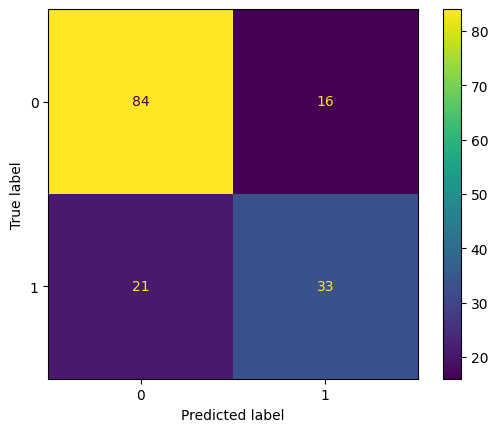

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
